In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib as plt

In [2]:
df = pd.read_csv(r"..\new_datasets\datos_gramineas.csv")
df['fecha'] = pd.to_datetime(df['fecha'])

### Adding Biological features (last year)

In [3]:
years = df['fecha'].dt.year.unique()
memory_features = []
    
for year in years:
    # Datos de este año
    mask_year = df['fecha'].dt.year == year
    df_year = df[mask_year].copy()
        
    if len(df_year) < 260: 
        continue

    mask_am = df_year['fecha'].dt.month.isin([4, 5])
    mask_ma = df_year['fecha'].dt.month.isin([3, 4, 5, 6, 7, 8])
    mask_summer = df_year['fecha'].dt.month.isin([6, 7, 8])
    mask_autumn = df_year['fecha'].dt.month.isin([10, 11, 12])
    mask_winter = df_year['fecha'].dt.month.isin([1, 2, 3])

    precip_autumn = df_year.loc[mask_autumn, 'rain (mm)'].sum()
    precip_winter = df_year.loc[mask_winter, 'rain (mm)'].sum()
    temp_mean_ss = df_year.loc[mask_ma, 'temperature_2m (°C)'].mean()
    humidity_sum_ss = df_year.loc[mask_ma, 'relative_humidity_2m (%)'].sum()
    co2_mean_am = df_year.loc[mask_am, 'CO (mg/m3)'].mean()
    o3_mean_am = df_year.loc[mask_am, 'O3 (ug/m3)'].mean()
    no2_mean_am = df_year.loc[mask_am, 'NO2 (ug/m3)'].mean()
    drought_days = (df_year.loc[mask_summer, 'rain (mm)'] < 1.0).sum()
    mask_gdd = (df_year['fecha'].dt.month >= 2)
    gdd = (df_year.loc[mask_gdd, 'temperature_2m (°C)'] - 5).clip(lower=0).sum()

    memory_features.append({
        'year_target': year + 1,
        'precip_autumn_last_year': precip_autumn,
        'precip_winter_last_year': precip_winter,
        'temp_mean_spring_summer_last': temp_mean_ss,
        'humidity_sum_spring_summer_last': humidity_sum_ss,
        'co2_mean_april_may_last': co2_mean_am,
        'o3_mean_april_may_last': o3_mean_am,
        'no2_mean_april_may_last': no2_mean_am,
        'drought_days_summer_last': drought_days,
        'growing_degree_days_last': gdd
    })
    
df_memory = pd.DataFrame(memory_features)
df['year'] = df['fecha'].dt.year
df = pd.merge(df, df_memory, left_on='year', right_on='year_target', how='left')
df.drop(columns=['year_target', 'year'], inplace=True)
df

,fecha,granos_de_polen_x_metro_cubico,temperature_2m (°C),wind_speed_10m (km/h),wind_gusts_10m (km/h),relative_humidity_2m (%),wind_direction_10m (°),et0_fao_evapotranspiration (mm),dew_point_2m (°C),rain (mm),...,Tolueno (ug/m3),precip_autumn_last_year,precip_winter_last_year,temp_mean_spring_summer_last,humidity_sum_spring_summer_last,co2_mean_april_may_last,o3_mean_april_may_last,no2_mean_april_may_last,drought_days_summer_last,growing_degree_days_last
0,2026-02-09,NaN,8.579417,12.180443,30.449999,89.875000,212.823685,0.036493,6.939466,0.016667,...,NaN,4.620833,3.258333,15.009851,12098.625,0.231034,68.896552,21.068966,90.0,2425.966667
1,2026-02-08,NaN,6.231427,9.430068,24.427500,81.302086,255.424850,0.056109,3.027426,0.058333,...,NaN,4.620833,3.258333,15.009851,12098.625,0.231034,68.896552,21.068966,90.0,2425.966667
2,2026-02-07,NaN,4.865083,8.106316,24.584999,90.125000,156.910263,0.018861,3.369081,0.325000,...,NaN,4.620833,3.258333,15.009851,12098.625,0.231034,68.896552,21.068966,90.0,2425.966667
3,2026-02-06,NaN,7.719250,10.279454,31.304998,83.375000,231.664200,0.039042,5.015291,0.000000,...,NaN,4.620833,3.258333,15.009851,12098.625,0.231034,68.896552,21.068966,90.0,2425.966667
4,2026-02-05,NaN,10.348416,13.838428,41.715000,85.291664,209.245224,0.053129,7.842015,0.362500,...,NaN,4.620833,3.258333,15.009851,12098.625,0.231034,68.896552,21.068966,90.0,2425.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4418,2014-01-05,0.0,4.987500,12.566667,23.804167,91.958333,227.375000,0.009583,3.770833,0.008333,...,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4419,2014-01-04,1.0,6.216667,15.016667,29.950000,85.125000,171.166667,0.020417,3.904167,0.045833,...,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4420,2014-01-03,0.0,5.587500,14.808333,27.833333,87.875000,195.541667,0.018333,3.683333,0.000000,...,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4421,2014-01-02,0.0,3.341667,15.962500,28.450000,85.958333,171.000000,0.015833,1.170833,0.000000,...,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Polen

In [4]:
# Polen últimos días
df['polen_rolling_mean_3d'] = df['granos_de_polen_x_metro_cubico'].shift(1).rolling(window=3, min_periods=1).mean()
df['polen_rolling_mean_7d'] = df['granos_de_polen_x_metro_cubico'].shift(1).rolling(window=7, min_periods=1).mean()

# Lags de polen (1-7 días)
for i in range(1, 8):
    df[f'polen_lag_{i}'] = df['granos_de_polen_x_metro_cubico'].shift(i)

# Lags de medias móviles (1-7 días)
for i in range(1, 8):
    for col in ['polen_rolling_mean_3d', 'polen_rolling_mean_7d']:
         df[f'{col}_lag_{i}'] = df[col].shift(i)

### Lag Contaminantes y Meteo (3 días)

In [5]:
cols = [
    'NO2 (ug/m3)', 'O3 (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'CO (mg/m3)', 'SO2 (ug/m3)',
    'Benceno (ug/m3)', 'Tolueno (ug/m3)', 'NO (ug/m3)', 'NOx (ug/m3)',
    'temperature_2m (°C)', 'wind_speed_10m (km/h)', 'wind_gusts_10m (km/h)',
    'relative_humidity_2m (%)', 'wind_direction_10m (°)', 'et0_fao_evapotranspiration (mm)',
    'dew_point_2m (°C)', 'rain (mm)', 'vapour_pressure_deficit (kPa)',
    'cloud_cover (%)', 'shortwave_radiation (W/m²)'
]

for col in cols:
    if col in df.columns:
        for i in range(1, 4):
            df[f'{col}_lag_{i}'] = df[col].shift(i)

### Predicción Meteo (3 días)

In [6]:
for h in [1, 2, 3]:
    df[f'temperature_forecast_t+{h}'] = df['temperature_2m (°C)'].shift(-h)
    df[f'rain_forecast_t+{h}'] = df['rain (mm)'].shift(-h)
    df[f'humidity_forecast_t+{h}'] = df['relative_humidity_2m (%)'].shift(-h)

### Guardar dataframe

In [7]:
df.to_csv(r"..\new_datasets\datos_gramineas.csv", index=False)

### Train Model (t+1)

In [8]:
FEATURES = [
    'NO2 (ug/m3)', 'O3 (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'CO (mg/m3)', 'SO2 (ug/m3)',
    'Benceno (ug/m3)', 'Tolueno (ug/m3)', 'NO (ug/m3)', 'NOx (ug/m3)',
    'temperature_2m (°C)', 'wind_speed_10m (km/h)', 'wind_gusts_10m (km/h)',
    'relative_humidity_2m (%)', 'wind_direction_10m (°)', 'et0_fao_evapotranspiration (mm)',
    'dew_point_2m (°C)', 'rain (mm)', 'vapour_pressure_deficit (kPa)',
    'cloud_cover (%)', 'shortwave_radiation (W/m²)'
]

for col in FEATURES.copy():
    for i in range(1, 4):
        FEATURES.append(f'{col}_lag_{i}')

FEATURES += [
    'precip_autumn_last_year', 'precip_winter_last_year',
    'temp_mean_spring_summer_last', 'humidity_sum_spring_summer_last',
    'co2_mean_april_may_last', 'o3_mean_april_may_last', 
    'no2_mean_april_may_last', 'drought_days_summer_last', 
    'growing_degree_days_last'
]

FEATURES += ['polen_rolling_mean_3d', 'polen_rolling_mean_7d']

for i in range(1, 8):
    FEATURES.append(f'polen_lag_{i}')

for i in range(1, 8):
    for col in ['polen_rolling_mean_3d', 'polen_rolling_mean_7d']:
         FEATURES.append(f'{col}_lag_{i}')

for h in [1, 2, 3]:
    FEATURES += [f'temperature_forecast_t+{h}', f'rain_forecast_t+{h}', f'humidity_forecast_t+{h}']

In [9]:
TARGET = 'granos_de_polen_x_metro_cubico'

# Eliminar filas nulas
df = df.dropna(subset=[TARGET])

X_train = df[FEATURES]
y_train = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=1000,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01)

reg.fit(X_train, y_train, verbose=100)

reg.get_booster().save_model('modelo_t+1.json')

### Prueba con 2024

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

train_data = df[df['fecha'].dt.year < 2024].dropna(subset=[TARGET])
test_data = df[df['fecha'].dt.year == 2024].dropna(subset=[TARGET])

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=1000,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

preds = reg.predict(test_data[FEATURES])

test_data['prediccion'] = preds

[0]	validation_0-rmse:31.39692	validation_1-rmse:28.20749
[100]	validation_0-rmse:18.29473	validation_1-rmse:19.54365
[200]	validation_0-rmse:13.33802	validation_1-rmse:17.94231
[300]	validation_0-rmse:10.82961	validation_1-rmse:17.89072
[400]	validation_0-rmse:9.71421	validation_1-rmse:17.99090
[500]	validation_0-rmse:8.83655	validation_1-rmse:17.94294
[600]	validation_0-rmse:8.24170	validation_1-rmse:17.75960
[700]	validation_0-rmse:7.78876	validation_1-rmse:17.60410
[800]	validation_0-rmse:7.37049	validation_1-rmse:17.63158
[900]	validation_0-rmse:7.01553	validation_1-rmse:17.67668
[999]	validation_0-rmse:6.72853	validation_1-rmse:17.68628


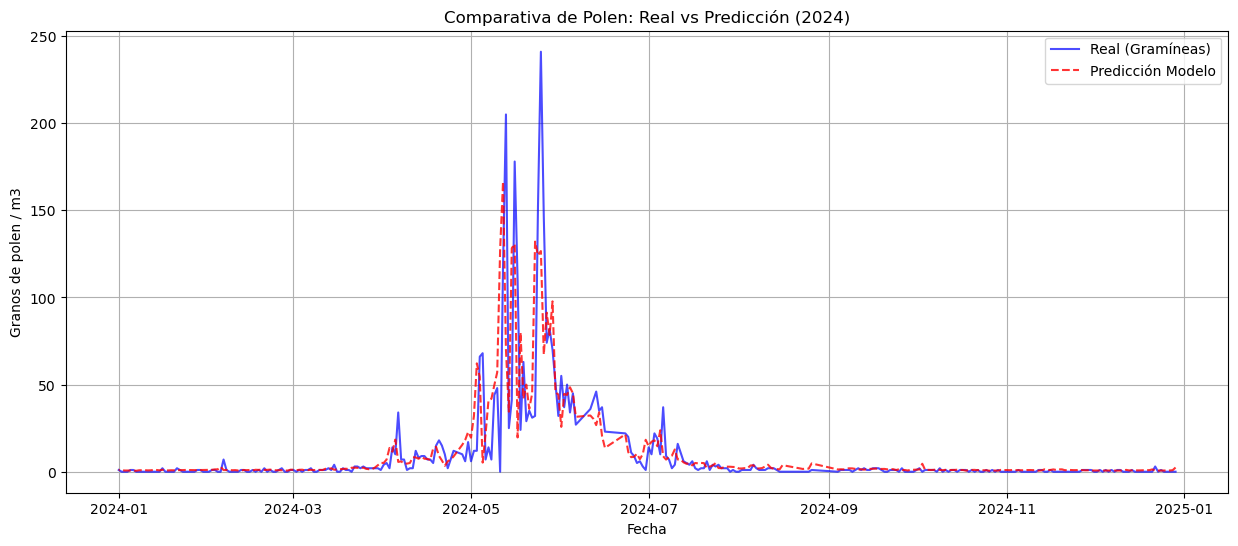

--- Métricas para el año 2024 ---
Error Medio Absoluto (MAE): 5.68 granos
Coeficiente de determinación (R2): 0.57


In [11]:
# Visualizar todo el año

plt.figure(figsize=(15, 6))

plt.plot(test_data['fecha'], test_data['granos_de_polen_x_metro_cubico'], label='Real (Gramíneas)', color='blue', alpha=0.7)
plt.plot(test_data['fecha'], test_data['prediccion'], label='Predicción Modelo', color='red', linestyle='--', alpha=0.8)

plt.title(f'Comparativa de Polen: Real vs Predicción (2024)')
plt.xlabel('Fecha')
plt.ylabel('Granos de polen / m3')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(test_data['granos_de_polen_x_metro_cubico'], test_data['prediccion'])
r2 = r2_score(test_data['granos_de_polen_x_metro_cubico'], test_data['prediccion'])

print(f"--- Métricas para el año 2024 ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} granos")
print(f"Coeficiente de determinación (R2): {r2:.2f}")

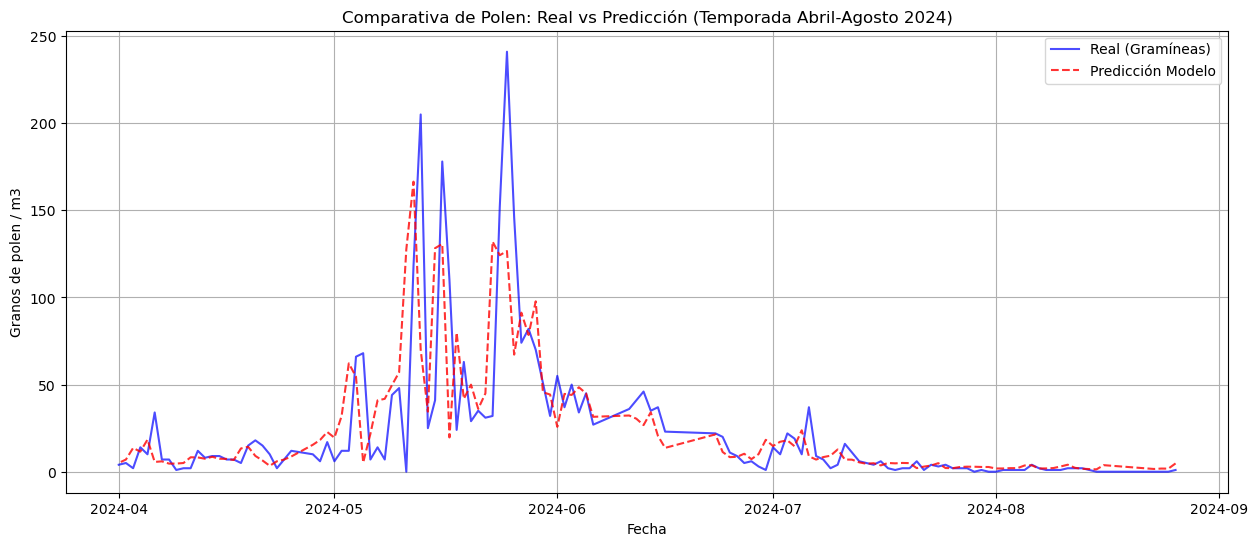

--- Métricas para el periodo Abril-Agosto 2024 ---
Error Medio Absoluto (MAE): 13.52 granos
Coeficiente de determinación (R2): 0.48


In [12]:
# Solo meses importantes

test_data_temporada = test_data[test_data['fecha'].dt.month.between(4, 8)].copy()

plt.figure(figsize=(15, 6))

plt.plot(test_data_temporada['fecha'], test_data_temporada['granos_de_polen_x_metro_cubico'], 
         label='Real (Gramíneas)', color='blue', alpha=0.7)
plt.plot(test_data_temporada['fecha'], test_data_temporada['prediccion'], 
         label='Predicción Modelo', color='red', linestyle='--', alpha=0.8)

plt.title(f'Comparativa de Polen: Real vs Predicción (Temporada Abril-Agosto 2024)')
plt.xlabel('Fecha')
plt.ylabel('Granos de polen / m3')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(test_data_temporada['granos_de_polen_x_metro_cubico'], test_data_temporada['prediccion'])
r2 = r2_score(test_data_temporada['granos_de_polen_x_metro_cubico'], test_data_temporada['prediccion'])

print(f"--- Métricas para el periodo Abril-Agosto 2024 ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} granos")
print(f"Coeficiente de determinación (R2): {r2:.2f}")